# **PyTorch Lecture 12: RNN1 - Basics**
---

In [266]:
import torch
import torch.nn as nn
import torch.optim  as optim

import statistics as st

In [216]:
cell = nn.RNN(input_size = 4, hidden_size = 2, num_layers = 1, nonlinearity = 'tanh', batch_first = True, bias = True)
print(f'Weights:\n{cell.weight_ih_l0.shape}\n\nBias:\n{cell.bias_ih_l0.shape}')

Weights:
torch.Size([2, 4])

Bias:
torch.Size([2])


In [217]:
h_h = torch.Tensor([[[1,0,0,0]]]) #The first dimmensions depends of the batch size
hid = torch.randn(1,1,2) #(num_layers * num_directions, batch, hidden_size)
print(f'Input:  \t{h_h.shape} \n{h_h}\n \nHidden: \t{hid.shape} \n{hid}')

Input:  	torch.Size([1, 1, 4]) 
tensor([[[1., 0., 0., 0.]]])
 
Hidden: 	torch.Size([1, 1, 2]) 
tensor([[[-0.4157, -0.4083]]])


In [218]:
out, hidden = cell(h_h, hid)
print(f'Output:  \t{out.shape} \n{out.data}\n \nHidden: \t{hidden.shape} \n{hidden.data}')

Output:  	torch.Size([1, 1, 2]) 
tensor([[[-0.5569,  0.3230]]])
 
Hidden: 	torch.Size([1, 1, 2]) 
tensor([[[-0.5569,  0.3230]]])


> Unfolding to n sequences
---

In [219]:
h = [1,0,0,0]
e = [0,1,0,0]
l = [0,0,1,0]
o = [0,0,0,1]
inputs = torch.Tensor([[h,e,l,l,o]])
print(f'Input shape: {inputs.shape}')

Input shape: torch.Size([1, 5, 4])


In [220]:
out, hidden = cell(inputs, hid)
print(f'Output:  \t{out.shape} \n\n{out.data}\n \n\nHidden: \t{hidden.shape} \n\n{hidden.data}')

Output:  	torch.Size([1, 5, 2]) 

tensor([[[-0.5569,  0.3230],
         [-0.5667, -0.8509],
         [-0.8251, -0.6449],
         [-0.8742, -0.7349],
         [-0.7520,  0.3751]]])
 

Hidden: 	torch.Size([1, 1, 2]) 

tensor([[[-0.7520,  0.3751]]])


> Batching input
---

In [221]:
inputs_batch = torch.Tensor([[h,e,l,l,o],[e,o,l,l,l],[h,o,l,l,o]])
print(f'Input shape: {list(inputs_batch.shape)}')
print(f'\t\t\t 3 -> Batch size\n\t\t\t 5 -> Number of letters\n\t\t\t 4 -> One hot vector lenght')

Input shape: [3, 5, 4]
			 3 -> Batch size
			 5 -> Number of letters
			 4 -> One hot vector lenght


In [222]:
#Now with the batch size of 3, the hidden shape must be changed too
hid_batch = torch.randn(1,3,2)
                 #(num_layer * num_directions, batch, hidden_size) 
print(f'Hidden shape: {list(hid_batch.shape)}')

Hidden shape: [1, 3, 2]


In [223]:
out_batch, hidden_batch = cell(inputs_batch, hid_batch)
print(f'Output:  \t{out_batch.shape} \n\n{out_batch.data}\n \n\nHidden: \t{hidden_batch.shape} \n\n{hidden_batch.data}')

Output:  	torch.Size([3, 5, 2]) 

tensor([[[-0.6505,  0.4281],
         [-0.6090, -0.8701],
         [-0.8340, -0.6497],
         [-0.8756, -0.7356],
         [-0.7524,  0.3749]],

        [[-0.6243, -0.8603],
         [-0.6677,  0.4881],
         [-0.8496, -0.8641],
         [-0.8775, -0.6991],
         [-0.8822, -0.7343]],

        [[-0.6412, -0.2346],
         [-0.6774,  0.2831],
         [-0.8509, -0.8442],
         [-0.8778, -0.7031],
         [-0.7532,  0.3636]]])
 

Hidden: 	torch.Size([1, 3, 2]) 

tensor([[[-0.7524,  0.3749],
         [-0.8822, -0.7343],
         [-0.7532,  0.3636]]])


### Training the first RNN
---

> Data preparation

In [280]:
#Index for unique letters
idx2char = ['h','i','e','l','o']
        #    0   1   2   3   4

one_hot_lo = [[1,0,0,0,0],  # -> 0
              [0,1,0,0,0],  # -> 1
              [0,0,1,0,0],  # -> 2
              [0,0,0,1,0],  # -> 3
              [0,0,0,0,1]]  # -> 4

x_data = [0,1,0,2,3,3] #hihell
x_one_hot = [one_hot_lo[x] for x in x_data]

y_data = [1,0,2,3,3,4]  #ihello => This is what we want to predict
y_one_hot = [one_hot_lo[x] for x in y_data]

one_hot_size = len(one_hot_lo[0])

inputs = torch.Tensor(x_one_hot).view(1,len(x_data),-1)
labels = torch.Tensor(y_one_hot).view(1,len(x_data),-1)

hidden = torch.zeros(1,1,len(idx2char))

print(f'Inputs shape: {list(inputs.shape)}\t\tHidden shape: {list(hidden.shape)}\t\tLabels shape: {list(labels.shape)}')


Inputs shape: [1, 6, 5]		Hidden shape: [1, 1, 5]		Labels shape: [1, 6, 5]


> Model

In [281]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rnn = nn.RNN(one_hot_size, one_hot_size, batch_first = True)
        
    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        return out, hidden   

In [282]:
rnn = Model()
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn.parameters(),lr= 0.0002)
output_rnn, hidden_rnn = rnn(inputs,hidden)
print(f'Output:  \t{output_rnn.shape} \n\n{output_rnn.data}\n \n\nHidden: \t{hidden_rnn.shape} \n\n{hidden_rnn.data}')

Output:  	torch.Size([1, 6, 5]) 

tensor([[[ 0.0082, -0.1055, -0.6333, -0.6649,  0.1409],
         [-0.1106, -0.0915, -0.2151, -0.5443,  0.4216],
         [-0.0455, -0.4799, -0.7099, -0.6418,  0.1976],
         [-0.1409, -0.0830, -0.7381, -0.3330,  0.7737],
         [-0.1594, -0.7195, -0.7649, -0.7581,  0.5538],
         [ 0.0440, -0.7924, -0.7852, -0.7266,  0.7692]]])
 

Hidden: 	torch.Size([1, 1, 5]) 

tensor([[[ 0.0440, -0.7924, -0.7852, -0.7266,  0.7692]]])


In [283]:
val_keep = inputs[:,5:6,:]
val_keep

tensor([[[0., 0., 0., 1., 0.]]])

In [297]:
losses, losses_mean = [], []
for epoch in range(1):
    
    for i in range(6):

        rnn.zero_grad()

        hidden, output = rnn(inputs[:,i:i+1,:],hidden)
        print(output, labels[:,i:i+1,:],'\n\n')
        loss = criterion(output,labels[:,i:i+1,:])
        
        losses.append(loss.item())
        
        loss.backward(retain_graph=True)
        optimizer.step()
        
    losses_mean.append(st.mean(losses))
    losses.clear()
    print(f'Epoch: {epoch+1}\t\tLoss: {losses_mean[epoch]}') 

tensor([[[ 0.0075,  0.2021, -0.0072, -0.1319, -0.0039]]],
       grad_fn=<StackBackward>) tensor([[[0., 1., 0., 0., 0.]]]) 


tensor([[[ 0.3858,  0.4277,  0.2326,  0.0707, -0.1214]]],
       grad_fn=<StackBackward>) tensor([[[1., 0., 0., 0., 0.]]]) 


tensor([[[ 0.1687,  0.3263,  0.4354, -0.0082,  0.0352]]],
       grad_fn=<StackBackward>) tensor([[[0., 0., 1., 0., 0.]]]) 


tensor([[[-0.0815,  0.4999,  0.1741,  0.5498,  0.1630]]],
       grad_fn=<StackBackward>) tensor([[[0., 0., 0., 1., 0.]]]) 


tensor([[[ 0.0085,  0.0611, -0.0171,  0.1713,  0.0795]]],
       grad_fn=<StackBackward>) tensor([[[0., 0., 0., 1., 0.]]]) 


tensor([[[ 0.1994,  0.0030, -0.0394,  0.0763,  0.3621]]],
       grad_fn=<StackBackward>) tensor([[[0., 0., 0., 0., 1.]]]) 


Epoch: 1		Loss: 0.11367703974246979


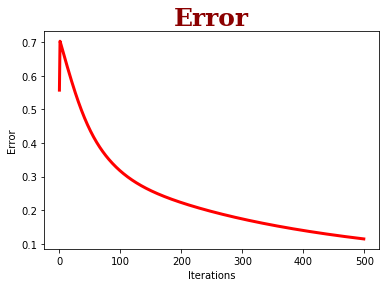

In [285]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(0,epoch+1),losses_mean,c='red',lw=3)

plt.title('Error', c='darkred', fontsize=25, weight='bold', family = 'serif')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.show()

In [287]:
hidden = torch.zeros(1,1,len(idx2char))
output_rnn, _ = rnn(inputs,hidden)

print(f'Output:  \t{output_rnn.shape} \n\n{output_rnn.data}\n')

Output:  	torch.Size([1, 6, 5]) 

tensor([[[ 0.0868,  0.2691,  0.0285, -0.0896,  0.0724],
         [ 0.3674,  0.4230,  0.2681,  0.0753, -0.1618],
         [ 0.1773,  0.3380,  0.4358, -0.0034,  0.0383],
         [-0.0829,  0.5021,  0.1791,  0.5479,  0.1588],
         [ 0.0090,  0.0646, -0.0156,  0.1678,  0.0779],
         [ 0.2000,  0.0045, -0.0368,  0.0738,  0.3601]]])



In [291]:
values, indices = torch.max(output_rnn, 1)

In [300]:
indices[0]

tensor([1, 3, 2, 3, 5])

In [299]:
for i in range(len(idx2char)):
    print(idx2char[indices[0][i]])

TypeError: only integer tensors of a single element can be converted to an index